In [11]:
#from google.colab import drive
#drive.mount('/content/drive')

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
from random import seed # for setting seed
import tensorflow
from IPython import sys_info
import os
import gc # garbage collection
import random
import os
import shutil

In [13]:
from tensorflow.python.client import device_lib
# print out the CPUs and GPUs
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12042179813244901185
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15242821632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4626046390909029668
physical_device_desc: "device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0"
xla_global_id: 416903419
]


2024-06-02 20:08:49.373422: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /device:GPU:0 with 14536 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


In [14]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [15]:
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Input

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence


In [16]:
folder = 'TOP100_ARTISTS_WITH_ALL_PICTURES'

# List the files in the folder
all_pictures = os.listdir(folder)

file_path = 'TOP100_ARTISTS_WITH_ALL_PICTURES.csv'
df = pd.read_csv(file_path)
print(df.head())

NUM_CLASSES = len(df['artist'].unique().tolist())

print("Number of classes:", NUM_CLASSES)


                    artist  date                 genre  pixelsx  pixelsy  \
0          Ivan Aivazovsky  1873                marina   7444.0   5811.0   
1                   Titian  1562         self-portrait   4524.0   6018.0   
2  Lucas Cranach the Elder  1534  allegorical painting   4344.0   6240.0   
3             Odilon Redon  1910     literary painting   4500.0   5738.0   
4           William Turner  1839                marina   5684.0   4226.0   

   size_bytes   source                         style  \
0   3189597.0  wikiart                   Romanticism   
1   8847626.0  wikiart  Mannerism (Late Renaissance)   
2  11276229.0  wikiart          Northern Renaissance   
3   2707505.0  wikiart                     Symbolism   
4   5103820.0  wikiart                   Romanticism   

                                               title    artist_group  \
0                                       Storm at sea  train_and_test   
1                                      Self-portrait  train_an

# Create the TEST and TRAIN sets

In [17]:
import shutil

In [18]:
# GROUP THE FILES BY EACH ARTIST
def group_files_per_artist():
  data_per_artist = {}

  # Iterate over each row of the DataFrame
  for index, row in df.iterrows():
      artist = row['artist']
      new_filename = row['new_filename']

      # Check if the artist is already in the dictionary
      if artist in data_per_artist:
          # Add the new_filename to the existing list of the artist
          data_per_artist[artist].append(new_filename)
      else:
          # Create a new list for the artist and add the new_filename
          data_per_artist[artist] = [new_filename]

  return data_per_artist

# SPLIT THE FILES INTO TRAIN AND TEST SETS (CREATE NEW DATASETS)
def split_test_train(data_per_artist, train_percentage = 0.8):

  TRAIN_names = []
  TEST_names = []

  # Iterate over each artist and their 'new_filename'
  for artist, filenames in data_per_artist.items():
      # Calculate the number of files for training and testing
      total_files = len(filenames)
      num_train = int(train_percentage * total_files)

      # Shuffle the filenames to avoid selection biases
      random.shuffle(filenames)

      # Divide the filenames into train and test
      train_filenames = filenames[:num_train]
      test_filenames = filenames[num_train:]

      # Store the divided filenames into train and test
      TRAIN_names.extend(train_filenames)
      TEST_names.extend(test_filenames)
  return TRAIN_names, TEST_names



# CREATE TEST and TRAIN folders
def create_train_test_folders(folder, TRAIN_names, TEST_names):
    # Output folder for TRAIN and TEST
    train_folder = os.path.join(folder, 'TRAIN')
    test_folder = os.path.join(folder, 'TEST')

    # Create TRAIN and TEST folders if they don't exist
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Move images from TRAIN to TRAIN folder
    for filename in TRAIN_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(train_folder, filename)
        shutil.move(src, dst)

    # Move images from TEST to TEST folder
    for filename in TEST_names:
        src = os.path.join(folder, filename)
        dst = os.path.join(test_folder, filename)
        shutil.move(src, dst)

    # Create df_train with rows whose 'new_filename' is in TRAIN_names and keep only 'artist' and 'new_filename' columns
    train_dataframe = df[df['new_filename'].isin(TRAIN_names)][['artist', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'train_dataframe.csv')
    # Save the DataFrame as CSV
    train_dataframe.to_csv(file_path, index=False)

    # Create df_test with rows whose 'new_filename' is in TEST_names and keep only 'artist' and 'new_filename' columns
    test_dataframe = df[df['new_filename'].isin(TEST_names)][['artist', 'new_filename']]
    # File path for the CSV file
    file_path = os.path.join(folder, 'test_dataframe.csv')
    # Save the DataFrame as CSV
    test_dataframe.to_csv(file_path, index=False)

    return train_dataframe, test_dataframe

if not (os.path.exists(os.path.join(folder, 'TRAIN')) and os.path.exists(os.path.join(folder, 'TEST'))):
  # Group files per artist
  data_per_artist = group_files_per_artist()
  # Print the number of files for each artist
  print("- Artists and numer of images:")
  for key in data_per_artist.keys():
    print(key, len(data_per_artist[key]))

  # Split data
  TRAIN_names, TEST_names = split_test_train(data_per_artist)

  # Use the function to create TRAIN and TEST folders
  train_dataframe, test_dataframe = create_train_test_folders(folder, TRAIN_names, TEST_names)
  print("\nImages successfully moved to TRAIN and TEST folders.")
else:
  print("TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...")

  # Read train and test DataFrames from CSV files
  train_csv_path = os.path.join(folder, 'train_dataframe.csv')
  test_csv_path = os.path.join(folder, 'test_dataframe.csv')
  train_dataframe = pd.read_csv(train_csv_path)
  test_dataframe = pd.read_csv(test_csv_path)

  print("Train DataFrame:", train_dataframe.shape)
  print("Test DataFrame:", test_dataframe.shape)
  

TRAIN and TEST folders already exist. Reading train and test DataFrames from CSV files...
Train DataFrame: (23057, 2)
Test DataFrame: (5808, 2)


# Prepare the data

In [19]:
from torchvision import datasets, transforms

# Define the transformation to convert images to PyTorch tensors
transf = transforms.Compose([transforms.ToTensor()])

# Paths of the training and testing folders
train_folder = folder+'/TRAIN'
test_folder = folder+'/TEST'

# Get the file names of training and testing images from the dataframes
train_filenames = train_dataframe['new_filename'].tolist()
test_filenames = test_dataframe['new_filename'].tolist()

print(len(train_filenames))


# Create empty lists for images and labels
train_images = []
train_labels = []
test_images = []
test_labels = []

# Load training images
for filename in train_filenames:
    img_path = os.path.join(train_folder, filename)
    img = Image.open(img_path)
    img_tensor = transf(img)
    train_images.append(img_tensor)
    # Get label from the dataframe
    label = train_dataframe[train_dataframe['new_filename'] == filename]['artist'].iloc[0]
    train_labels.append(label)
# Load testing images
for filename in test_filenames:
    img_path = os.path.join(test_folder, filename)
    img = Image.open(img_path)
    img_tensor = transf(img)
    test_images.append(img_tensor)
    # Get label from the dataframe
    label = test_dataframe[test_dataframe['new_filename'] == filename]['artist'].iloc[0]
    test_labels.append(label)


23057


In [20]:
import torch

# Create a dictionary to map artist names to unique numerical values
artist_to_index = {artist: i for i, artist in enumerate(train_dataframe['artist'].unique())}

# Convert string labels to integers using the dictionary
train_labels = [artist_to_index[artist] for artist in train_labels]
test_labels = [artist_to_index[artist] for artist in test_labels]

# Create PyTorch tensors for training and testing images and labels
train_dataset = torch.utils.data.TensorDataset(torch.stack(train_images), torch.tensor(train_labels))
all_test_dataset = torch.utils.data.TensorDataset(torch.stack(test_images), torch.tensor(test_labels))


In [21]:
print(f'Shape of training set: {train_dataset.tensors[0].shape}')
print(f'Shape of test set: {all_test_dataset.tensors[0].shape}')
print(f'Shape of training labels: {train_dataset.tensors[1].shape}')
print(f'Shape of test labels: {all_test_dataset.tensors[1].shape}')

Shape of training set: torch.Size([23057, 3, 224, 224])
Shape of test set: torch.Size([5808, 3, 224, 224])
Shape of training labels: torch.Size([23057])
Shape of test labels: torch.Size([5808])


In [22]:
import collections

# Get the labels from the training and test datasets
y_train = train_dataset.tensors[1].tolist()
y_test = all_test_dataset.tensors[1].tolist()

# Count the number of images per category in the training data
counter_train = collections.Counter(y_train)
print('Class Image Counter for Training Data:')
print(counter_train)

# Count the number of images per category in the test data
counter_test = collections.Counter(y_test)
print('\nClass Image Counter for Test Data:')
print(counter_test)


Class Image Counter for Training Data:
Counter({86: 395, 67: 394, 40: 388, 39: 384, 84: 384, 15: 383, 38: 380, 73: 380, 33: 377, 68: 372, 89: 372, 64: 368, 72: 363, 30: 361, 47: 359, 35: 354, 0: 353, 29: 351, 69: 349, 17: 346, 19: 344, 43: 325, 37: 320, 97: 320, 71: 300, 79: 300, 41: 285, 80: 282, 5: 280, 55: 262, 82: 258, 3: 257, 31: 256, 50: 256, 49: 249, 14: 243, 57: 242, 70: 241, 21: 240, 92: 232, 56: 230, 63: 227, 34: 226, 20: 220, 95: 217, 99: 212, 98: 207, 93: 203, 6: 192, 32: 192, 75: 192, 83: 191, 12: 190, 54: 188, 59: 188, 78: 187, 61: 184, 52: 183, 77: 183, 8: 181, 1: 180, 27: 180, 94: 180, 48: 176, 60: 176, 88: 176, 53: 171, 81: 171, 46: 168, 10: 167, 91: 164, 16: 163, 24: 162, 2: 161, 44: 161, 74: 160, 7: 156, 36: 156, 28: 154, 66: 153, 22: 152, 65: 152, 23: 148, 90: 148, 9: 144, 13: 144, 87: 144, 76: 143, 96: 143, 18: 141, 85: 141, 58: 140, 4: 138, 11: 138, 26: 137, 51: 136, 42: 135, 45: 134, 25: 133, 62: 133})

Class Image Counter for Test Data:
Counter({86: 99, 67: 99, 

In [23]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the labels from the test dataset
y_test = all_test_dataset.tensors[1].tolist()

# Use StratifiedShuffleSplit to split the data into validation set and test set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# Make a list of indices for the test set
indices_test = list(range(len(all_test_dataset)))

# Execute the stratified split
for idx_test, idx_val in split.split(indices_test, y_test):
    val_dataframe = test_dataframe.loc[idx_val]
    print("Test Indices:", idx_test)
    print("Validation Indices:", idx_val)
    print("Number of samples in validation set:", len(idx_val))
    print("Number of samples in test set:", len(idx_test))


Test Indices: [ 897 2938  651 ... 3628 4514 2759]
Validation Indices: [ 609 4545 2940 ... 5046 3106 1001]
Number of samples in validation set: 1162
Number of samples in test set: 4646


# Create two datasets from all_test_dataset

In [24]:
from torch.utils.data import Subset

# Use torch utility to make subsets for all_test_dataset

val_dataset = Subset(all_test_dataset, idx_val)  # List of indices for validation split
test_dataset = Subset(all_test_dataset, idx_test)  # List of indices for test split


In [25]:
# Get the labels from the validation and test datasets and convert them to integers
y_val = [int(all_test_dataset[idx][1]) for idx in idx_val]
y_test = [int(all_test_dataset[idx][1]) for idx in idx_test]

# Count the number of images per category in the validation data
counter_val = collections.Counter(y_val)
print('Class Image Counter for Validation Data:')
print(counter_val)

# Count the number of images per category in the test data
counter_test = collections.Counter(y_test)
print('\nClass Image Counter for Test Data:')
print(counter_test)


Class Image Counter for Validation Data:
Counter({40: 20, 67: 20, 84: 20, 86: 20, 39: 19, 64: 19, 68: 19, 73: 19, 89: 19, 15: 19, 33: 19, 38: 19, 72: 18, 29: 18, 35: 18, 69: 18, 30: 18, 0: 18, 47: 18, 19: 17, 17: 17, 43: 16, 97: 16, 37: 16, 71: 15, 79: 15, 41: 14, 5: 14, 80: 14, 49: 13, 3: 13, 31: 13, 55: 13, 82: 13, 50: 13, 92: 12, 21: 12, 57: 12, 56: 12, 14: 12, 70: 12, 95: 11, 20: 11, 99: 11, 63: 11, 34: 11, 75: 10, 6: 10, 32: 10, 54: 10, 83: 10, 98: 10, 12: 10, 93: 10, 78: 9, 60: 9, 48: 9, 94: 9, 8: 9, 27: 9, 46: 9, 59: 9, 61: 9, 81: 9, 1: 9, 53: 9, 77: 9, 88: 9, 52: 9, 24: 8, 44: 8, 10: 8, 2: 8, 7: 8, 91: 8, 66: 8, 16: 8, 22: 8, 65: 8, 36: 8, 28: 8, 74: 8, 11: 7, 13: 7, 51: 7, 87: 7, 85: 7, 76: 7, 26: 7, 58: 7, 96: 7, 23: 7, 90: 7, 4: 7, 42: 7, 62: 7, 25: 7, 45: 7, 18: 7, 9: 7})

Class Image Counter for Test Data:
Counter({67: 79, 86: 79, 40: 78, 15: 77, 39: 77, 84: 77, 38: 76, 73: 76, 33: 76, 68: 74, 89: 74, 72: 73, 30: 73, 64: 73, 47: 72, 0: 71, 35: 71, 29: 70, 17: 70, 69: 70, 1

In [26]:
import torchvision.utils as utils

def plot_img(img, title=None):
    npimg = img.numpy()
    npimg_T = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_T)
    if title:
        plt.title(title)
    plt.axis('on')
    plt.show()

# Function to visualize samples from a data tensor
def plot_tensor(tensor, random_id=False, class_id=None):
    if random_id:
        rnd_inds = np.random.randint(0, len(tensor), 100)
        X_show = [tensor[i][0] for i in rnd_inds]
    else:
        if class_id is None:
            X_show = []
            for j in range(NUM_CLASSES):  # NUM_CLASSES classes
                ii = -1
                for i in range(len(tensor)):
                    if tensor[i][1] == j:
                        ii += 1
                        if ii > 19:
                            break
                        else:
                            X_show.append(tensor[i][0])
        else:
            print(f'Showing samples from {len(tensor)} tensors:')
            X_show = []
            ii = -1
            for i in range(len(tensor)):
                if tensor[i][1] == class_id:
                    ii += 1
                    if ii > 19:
                        break
                    else:
                        X_show.append(tensor[i][0])

    X_grid = utils.make_grid(X_show, nrow=20, padding=1)
    plot_img(X_grid, title='Image samples from each class')


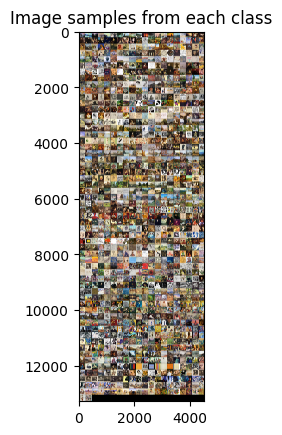

In [27]:
plot_tensor(val_dataset)

Showing samples from 1162 tensors:


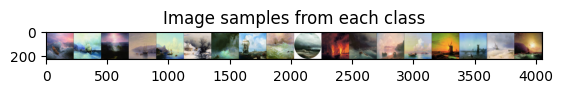

In [28]:
plot_tensor(val_dataset,class_id=0)

Showing samples from 1162 tensors:


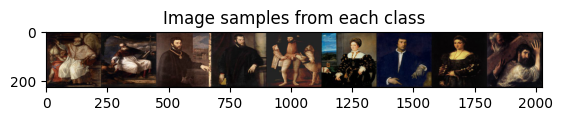

In [29]:
plot_tensor(val_dataset,class_id=1)

Showing samples from 1162 tensors:


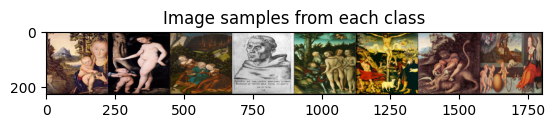

In [30]:
plot_tensor(val_dataset,class_id=2)

Showing samples from 1162 tensors:


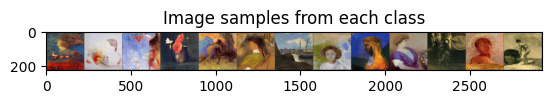

In [31]:
plot_tensor(val_dataset,class_id=3)

Showing samples from 1162 tensors:


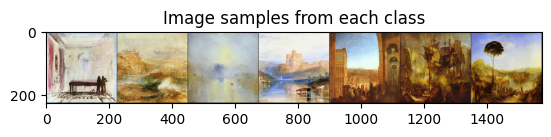

In [32]:
plot_tensor(val_dataset,class_id=4)

In [33]:
def get_meanstd(data):
    # List of lists of mean values for each image
    meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in data]
    stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in data]
    print('Mean & std values for sample:')
    print(meanRGB[0])
    print(stdRGB[0])

    # Calculate the global mean of the dataset from these means
    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    # Calculate the global standard deviation of the dataset
    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])

    print('\nMean value for dataset:')
    print(f'Mean Values: {meanR} {meanG} {meanB}')
    print(f'STD Values: {stdR} {stdG} {stdB}')

    return [meanR, meanG, meanB], [stdR, stdG, stdB]

means, stds = get_meanstd(train_dataset)


Mean & std values for sample:
[0.43174443 0.46031097 0.45549223]
[0.12931994 0.12496761 0.10158332]

Mean value for dataset:
Mean Values: 0.5187403559684753 0.4694617986679077 0.4069422781467438
STD Values: 0.21124403178691864 0.20092765986919403 0.18979398906230927


# Define the image transformations (for train_ds & test_all)

Showing samples from 23057 tensors:


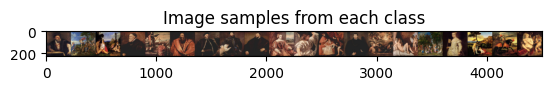

In [34]:
# Transformations for training set
train_transformer = transforms.Compose([transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomVerticalFlip(p=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize([means[0], means[1], means[2]],
                                                             [stds[0], stds[1], stds[2]])])

# Standard transformations for test set
test0_transformer = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize([means[0], means[1], means[2]],
                                                             [stds[0], stds[1], stds[2]])])

''' Update the transform functions for train_ds & test_all '''
train_dataset.transform = train_transformer
test_dataset.transform = test0_transformer

plot_tensor(train_dataset, class_id=1)  # Can plot the converted data after transformation


# Create dataloaders from train_ds & val_ds

In [35]:
from torch.utils.data import DataLoader



# Create Data Loaders (training)
train_dl = DataLoader(train_dataset,
                      batch_size=32,
                      shuffle=True)

# Create Data Loader (validation)
val_dl = DataLoader(val_dataset,
                    batch_size=64,
                    shuffle=False)

# And get a batch of data from train_dl
for x,y in train_dl:
    print(x.shape)
    print(y.shape)
    break

# Extract a batch of data from val_dl
for x,y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 224, 224])
torch.Size([32])
torch.Size([64, 3, 224, 224])
torch.Size([64])


# Defining a Loss Function

In [36]:
import torch.nn as nn


loss_func = nn.CrossEntropyLoss(reduction='sum')

In [37]:
# get the current learning rate helper function
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

In [38]:
def plot_out(loss_hist,metric_hist,epochs=None):

    # Train-Validation Progress
    fig = make_subplots(rows=1, cols=2,subplot_titles=['lost_hist','metric_hist'])

    # Plot Model Learning Rate
    fig.add_trace(go.Scatter(x=[*range(1,epochs+1)],
                             y=loss_hist["train"],
                             name='loss_hist["train"]',
                             line=dict(color="#0000ff")),row=1, col=1)
    fig.add_trace(go.Scatter(x=[*range(1,epochs+1)],
                             y=loss_hist["val"],
                             name='loss_hist["val"]'),row=1, col=1)

    # Plot Metric
    fig.add_trace(go.Scatter(x=[*range(1,epochs+1)],
                             y=metric_hist["train"],
                             name='metric_hist["train"]'),row=1, col=2)
    fig.add_trace(go.Scatter(x=[*range(1,epochs+1)],
                             y=metric_hist["val"],
                             name='metric_hist["val"]'),row=1, col=2)

    fig.update_layout(template='plotly_white')
    fig.update_layout(margin={"r":0,"t":60,"l":0,"b":0},height=300)
    fig.show()


# Training and Tranfer Learning

In [39]:
import copy


''' Helper function to count the number of correct predictions '''
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)

    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

''' Helper function to compute the loss value per batch of data '''
def loss_batch(loss_func, output, target, opt=None):

    # get loss
    loss = loss_func(output, target)

    # get performance metric
    metric_b = metrics_batch(output,target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

# define computation hardware approach (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Compute the Loss Value & Performance Metric

def loss_epoch(model,loss_func,dataset_dl,check_id=False,opt=None):

    # initialising variables
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    # internal loop
    for xb, yb in dataset_dl:

        xb=xb.to(device) # move X of batch to device
        yb=yb.to(device) # move y of batch to device

        output=model(xb) # get model output
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
        running_loss+=loss_b # update running loss

        if(metric_b is not None):
            running_metric+=metric_b # update running metric
        if(check_id):
            break # stop if only checking

    loss=running_loss/float(len_data) # average loss value
    metric=running_metric/float(len_data) # average metric value

    return loss, metric

In [40]:
''' TRAINING FUNCTION '''
# model - input model
# parameters - input parameter dictionary

def train_val(model, params, verbose = False):

    # extract model parameters
    epochs=params["epochs"]
    loss_func=params["loss_func"]
    opt=params["optimiser"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    check_id=params["check_id"]
    lr_scheduler=params["lr_scheduler"]
    path=params["path"]

    loss_history={"train": [],"val": []} # history of loss values in each epoch
    metric_history={"train": [],"val": []} # histroy of metric values in each epoch
    best_model_wts = copy.deepcopy(model.state_dict()) # copy weights for best model
    best_loss=float('inf') # initialize best loss to a large value

    # main loop
    for epoch in range(epochs):

        current_lr=get_lr(opt) # get current learning rate
        if(verbose):
            print(f"Epoch {epoch}/{epochs-1}, current lr={current_lr}")

        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,check_id,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        # evaluate model on validation dataset
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,check_id)


        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), path)
            if(verbose):
                print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step(val_loss)

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print('')

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [41]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plot_out(loss_hist, metric_hist, epochs=None):
    # Crear la figura y los ejes
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Gráfico de historial de pérdidas
    axs[0].plot(range(1, epochs+1), loss_hist["train"], label="Train loss")
    axs[0].plot(range(1, epochs+1), loss_hist["val"], label="Validation loss")
    axs[0].set_title('loss_hist')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Gráfico de historial de métricas
    axs[1].plot(range(1, epochs+1), metric_hist["train"], label="Train acc")
    axs[1].plot(range(1, epochs+1), metric_hist["val"], label="Validation acc")
    axs[1].set_title('acc_hist')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Ajustar el espaciado entre los subplots
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()


In [53]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import torchvision.transforms as transforms

# Load the pretrained DenseNet201 model
pre_densenet201 = models.densenet169(pretrained=True)

# Congelar todas las capas
for param in pre_densenet201.parameters():
    param.requires_grad = False

# Descongelar más capas para mejorar la capacidad de ajuste
#for param in pre_densenet201.features.denseblock4.parameters():
#    param.requires_grad = True

# Añadir Dropout a la capa totalmente conectada
num_ftrs = pre_densenet201.classifier.in_features
pre_densenet201.classifier = nn.Sequential(
    nn.BatchNorm1d(num_ftrs),
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, NUM_CLASSES)
)

for param in pre_densenet201.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pre_densenet201.to(device)

#Augmenting the data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
        transforms.RandomVerticalFlip(),
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}

# Assume train_dl and val_dl are already defined
# Apply data_transforms to the datasets
train_dl.dataset.transform = data_transforms['train']
val_dl.dataset.transform = data_transforms['val']


# Loss function
loss_func = nn.CrossEntropyLoss(reduction="sum")

# Define an optimiser with weight decay
optimiser = optim.Adagrad(filter(lambda p: p.requires_grad, pre_densenet201.parameters()), lr=1e-2, weight_decay=1e-2)

# Define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.9, patience=3, threshold=0.1, cooldown=0, min_lr=0, eps=1e-08, verbose=False)

# Set Training Parameters
params_train = {
    "epochs": 30,
    "optimiser": optimiser,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "check_id": False,
    "lr_scheduler": lr_scheduler,
    "path": "pre_densenet201.pt",
}

# Train and validate the model
pre_densenet201, loss_hist, metric_hist = train_val(pre_densenet201, params_train, verbose=True)


Epoch 0/29, current lr=0.01
Copied best model weights!
train loss: 2.572182, dev loss: 1.850826, accuracy: 55.68

Epoch 1/29, current lr=0.01
Copied best model weights!
train loss: 1.897360, dev loss: 1.713360, accuracy: 58.52

Epoch 2/29, current lr=0.01
Copied best model weights!
train loss: 1.733010, dev loss: 1.633726, accuracy: 59.90

Epoch 3/29, current lr=0.01
Copied best model weights!
train loss: 1.644673, dev loss: 1.598491, accuracy: 60.67

Epoch 4/29, current lr=0.01
Copied best model weights!
train loss: 1.571144, dev loss: 1.568597, accuracy: 61.10

Epoch 5/29, current lr=0.01
Copied best model weights!
train loss: 1.528324, dev loss: 1.534357, accuracy: 61.88

Epoch 6/29, current lr=0.01
Copied best model weights!
train loss: 1.509562, dev loss: 1.511953, accuracy: 63.68

Epoch 7/29, current lr=0.009000000000000001
Copied best model weights!
train loss: 1.467571, dev loss: 1.498476, accuracy: 62.48

Epoch 8/29, current lr=0.009000000000000001
Copied best model weights!
t

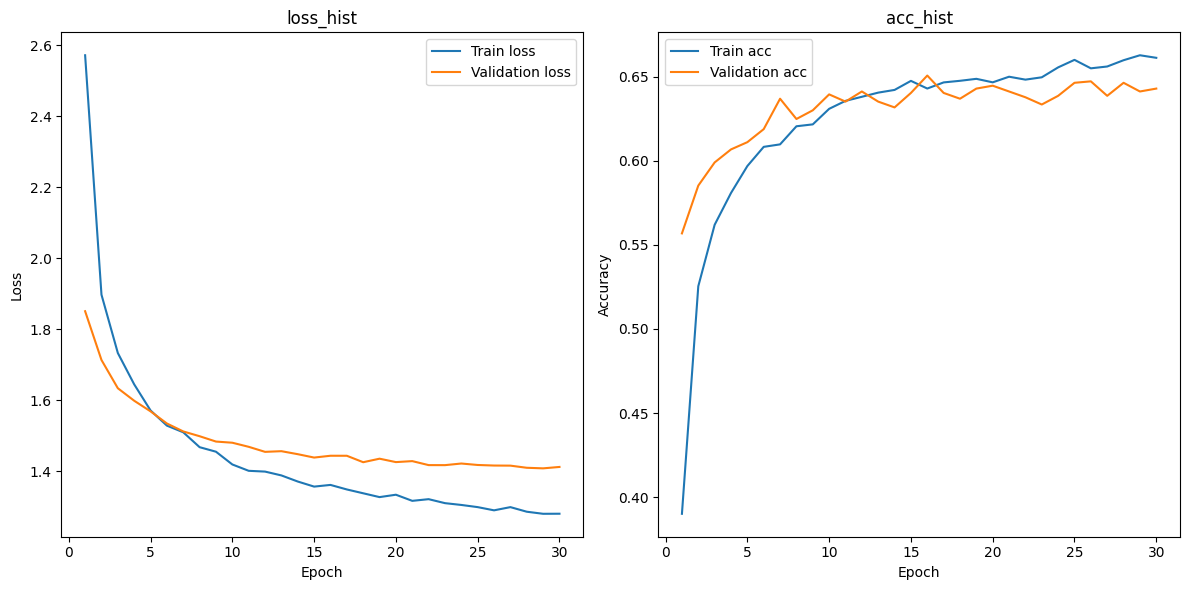

In [54]:
# Plot History
plot_out(loss_hist,metric_hist,epochs=params_train["epochs"])

# Evaluate per artist

In [55]:
def evaluate_model(model, dataloader):
    pre_densenet201.eval()  # set the model to evaluation mode
    correct_preds = {i: 0 for i in range(NUM_CLASSES)}  # dictionary to store correct predictions per class
    total_preds = {i: 0 for i in range(NUM_CLASSES)}    # dictionary to store total predictions per class

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for pred, label in zip(preds, labels):
                if pred == label:
                    correct_preds[label.item()] += 1
                total_preds[label.item()] += 1

    accuracy_per_class = {i: correct_preds[i] / total_preds[i] if total_preds[i] != 0 else 0 for i in range(NUM_CLASSES)}
    return correct_preds, total_preds, accuracy_per_class

correct_preds, total_preds, accuracy_per_class = evaluate_model(pre_densenet201, val_dl)

artistas = {index: artist for artist, index in artist_to_index.items()}

# Printing results
for i in range(len(artistas)):  # Iterate over the number of artists
    print(f"Artista {artistas[i]}:")
    print(f"  Total Predictions: {total_preds[i]}")
    print(f"  Correct Predictions: {correct_preds[i]}")
    print(f"  Incorrect Predictions: {total_preds[i] - correct_preds[i]}")
    print(f"  Accuracy: {accuracy_per_class[i]*100:.2f}%\n")

Artista Ivan Aivazovsky:
  Total Predictions: 18
  Correct Predictions: 16
  Incorrect Predictions: 2
  Accuracy: 88.89%

Artista Titian:
  Total Predictions: 9
  Correct Predictions: 5
  Incorrect Predictions: 4
  Accuracy: 55.56%

Artista Lucas Cranach the Elder:
  Total Predictions: 8
  Correct Predictions: 6
  Incorrect Predictions: 2
  Accuracy: 75.00%

Artista Odilon Redon:
  Total Predictions: 13
  Correct Predictions: 10
  Incorrect Predictions: 3
  Accuracy: 76.92%

Artista William Turner:
  Total Predictions: 7
  Correct Predictions: 4
  Incorrect Predictions: 3
  Accuracy: 57.14%

Artista Henri de Toulouse-Lautrec:
  Total Predictions: 14
  Correct Predictions: 8
  Incorrect Predictions: 6
  Accuracy: 57.14%

Artista Konstantin Somov:
  Total Predictions: 10
  Correct Predictions: 5
  Incorrect Predictions: 5
  Accuracy: 50.00%

Artista Gustave Caillebotte:
  Total Predictions: 8
  Correct Predictions: 3
  Incorrect Predictions: 5
  Accuracy: 37.50%

Artista Ferdinand Hodler

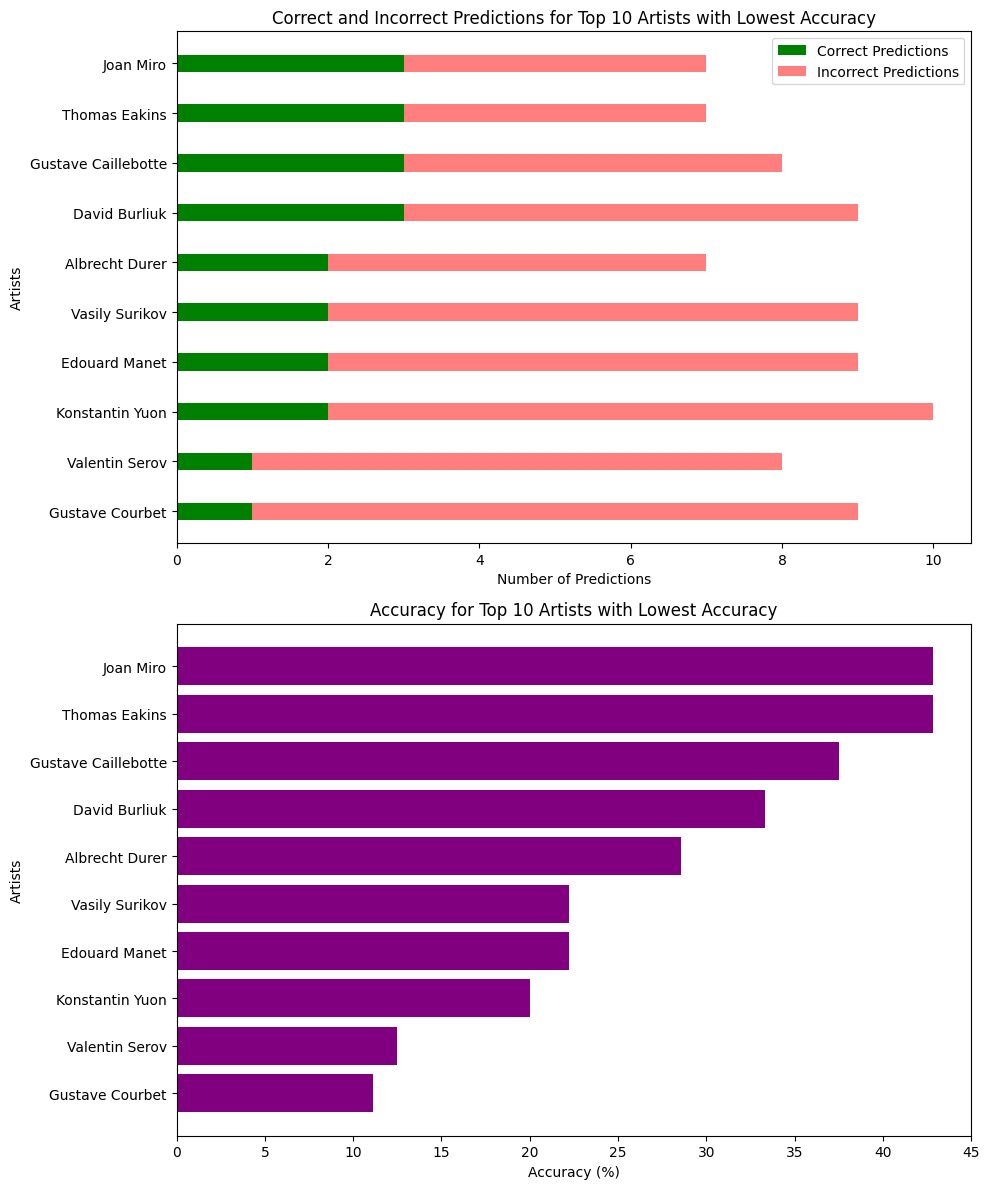

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que estas listas ya están definidas
artist_names = [artistas[i] for i in range(len(artistas))]
correct_predictions = [correct_preds[i] for i in range(len(artistas))]
incorrect_predictions = [total_preds[i] - correct_preds[i] for i in range(len(artistas))]
accuracy = [accuracy_per_class[i] * 100 for i in range(len(artistas))]

# Crear una lista de tuplas (artist_name, correct_predictions, incorrect_predictions, accuracy)
artist_data = list(zip(artist_names, correct_predictions, incorrect_predictions, accuracy))

# Ordenar por precisión en orden ascendente (menor precisión primero)
artist_data_sorted = sorted(artist_data, key=lambda x: x[3])

# Seleccionar los primeros 10 artistas con menor precisión
top_10_incorrect_artists = artist_data_sorted[:10]

# Desempaquetar los datos para los 10 artistas seleccionados
top_10_artist_names = [data[0] for data in top_10_incorrect_artists]
top_10_correct_predictions = [data[1] for data in top_10_incorrect_artists]
top_10_incorrect_predictions = [data[2] for data in top_10_incorrect_artists]
top_10_accuracy = [data[3] for data in top_10_incorrect_artists]

fig, axs = plt.subplots(2, 1, figsize=(10, 12))  # Ajustar el tamaño del gráfico si es necesario

bar_width = 0.35

# Correct and incorrect predictions graphics for top 10 incorrect artists
axs[0].barh(top_10_artist_names, top_10_correct_predictions, bar_width, label='Correct Predictions', color='g')
axs[0].barh(top_10_artist_names, top_10_incorrect_predictions, bar_width, left=top_10_correct_predictions, label='Incorrect Predictions', color='r', alpha=0.5)
axs[0].set_xlabel('Number of Predictions')
axs[0].set_ylabel('Artists')
axs[0].set_title('Correct and Incorrect Predictions for Top 10 Artists with Lowest Accuracy')
axs[0].legend()

# Accuracy by artist for top 10 incorrect artists
axs[1].barh(top_10_artist_names, top_10_accuracy, color='purple')
axs[1].set_xlabel('Accuracy (%)')
axs[1].set_ylabel('Artists')
axs[1].set_title('Accuracy for Top 10 Artists with Lowest Accuracy')

plt.tight_layout()
plt.show()


# Second model

In [45]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau
import torchvision.transforms as transforms

# Load the pretrained DenseNet201 model
pre_densenet201 = models.densenet169(pretrained=True)

# Congelar todas las capas
for param in pre_densenet201.parameters():
    param.requires_grad = False

# Descongelar más capas para mejorar la capacidad de ajuste
for param in pre_densenet201.features.denseblock4.parameters():
    param.requires_grad = True


# Añadir Dropout a la capa totalmente conectada
num_ftrs = pre_densenet201.classifier.in_features
pre_densenet201.classifier = nn.Sequential(
    nn.BatchNorm1d(num_ftrs),
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, NUM_CLASSES)
)

for param in pre_densenet201.classifier.parameters():
    param.requires_grad = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pre_densenet201.to(device)

#Augmenting the data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
        transforms.RandomVerticalFlip(),
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
}

# Assume train_dl and val_dl are already defined
# Apply data_transforms to the datasets
train_dl.dataset.transform = data_transforms['train']
val_dl.dataset.transform = data_transforms['val']


# Loss function
loss_func = nn.CrossEntropyLoss(reduction="sum")

# Define an optimiser with weight decay
optimiser = optim.Adagrad(filter(lambda p: p.requires_grad, pre_densenet201.parameters()), lr=1e-2, weight_decay=1e-2)

# Define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.9, patience=3, threshold=0.1, cooldown=0, min_lr=0, eps=1e-08, verbose=False)

# Set Training Parameters
params_train = {
    "epochs": 30,
    "optimiser": optimiser,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "check_id": False,
    "lr_scheduler": lr_scheduler,
    "path": "pre_densenet201.pt",
}

# Train and validate the model
pre_densenet201, loss_hist, metric_hist = train_val(pre_densenet201, params_train, verbose=True)

Epoch 0/29, current lr=0.01
Copied best model weights!
train loss: 2.173040, dev loss: 1.361727, accuracy: 66.09

Epoch 1/29, current lr=0.01
Copied best model weights!
train loss: 1.190630, dev loss: 1.146431, accuracy: 71.51

Epoch 2/29, current lr=0.01
Copied best model weights!
train loss: 0.786253, dev loss: 1.040005, accuracy: 74.10

Epoch 3/29, current lr=0.01
Copied best model weights!
train loss: 0.488757, dev loss: 1.020024, accuracy: 74.61

Epoch 4/29, current lr=0.01
Copied best model weights!
train loss: 0.277120, dev loss: 1.002438, accuracy: 75.22

Epoch 5/29, current lr=0.01
train loss: 0.162128, dev loss: 1.023754, accuracy: 74.01

Epoch 6/29, current lr=0.01
train loss: 0.093808, dev loss: 1.004655, accuracy: 74.87

Epoch 7/29, current lr=0.01
Copied best model weights!
train loss: 0.062042, dev loss: 0.993511, accuracy: 76.16

Epoch 8/29, current lr=0.009000000000000001
Copied best model weights!
train loss: 0.044435, dev loss: 0.991598, accuracy: 75.22

Epoch 9/29, 

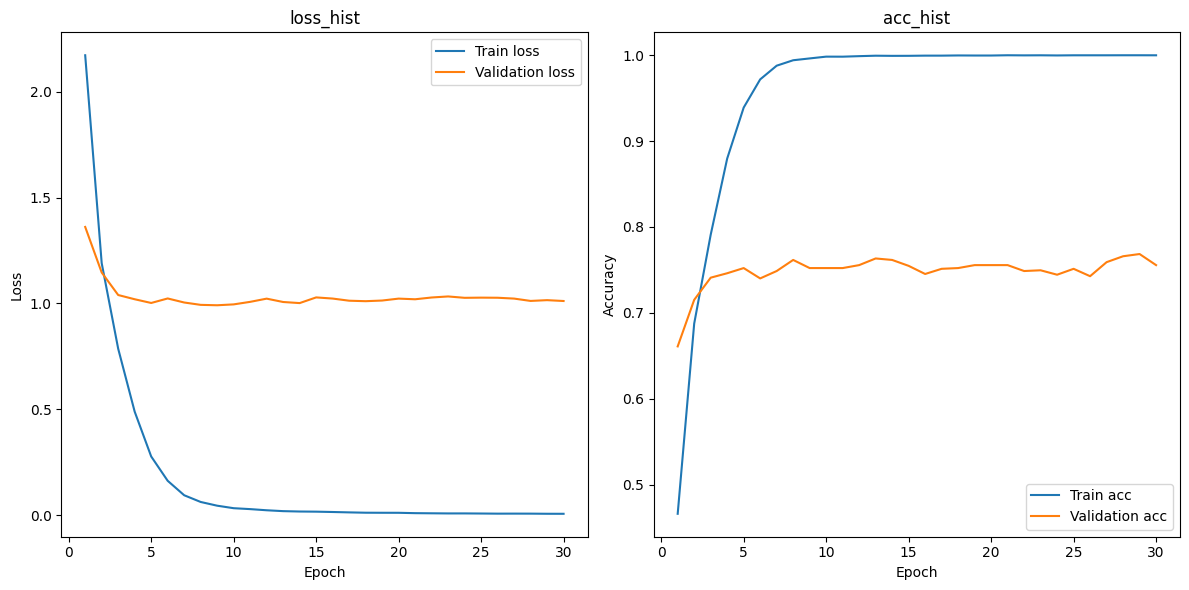

In [46]:
# Plot History
plot_out(loss_hist,metric_hist,epochs=params_train["epochs"])

In [47]:
# Seleccionar las filas para el conjunto de validación
val_dataframe = test_dataframe.loc[idx_val]

# Ruta del archivo CSV donde se guardará el val_dataframe
val_csv_path = os.path.join(folder, 'val_dataframe.csv')

# Guardar el DataFrame val_dataframe en un archivo CSV
val_dataframe.to_csv(val_csv_path, index=False)

print(f"Validation DataFrame successfully saved to {val_csv_path}")


Validation DataFrame successfully saved to TOP100_ARTISTS_WITH_ALL_PICTURES/val_dataframe.csv


# Evaluate per artist

In [50]:
def evaluate_model(model, dataloader):
    pre_densenet201.eval()  # set the model to evaluation mode
    correct_preds = {i: 0 for i in range(NUM_CLASSES)}  # dictionary to store correct predictions per class
    total_preds = {i: 0 for i in range(NUM_CLASSES)}    # dictionary to store total predictions per class

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for pred, label in zip(preds, labels):
                if pred == label:
                    correct_preds[label.item()] += 1
                total_preds[label.item()] += 1

    accuracy_per_class = {i: correct_preds[i] / total_preds[i] if total_preds[i] != 0 else 0 for i in range(NUM_CLASSES)}
    return correct_preds, total_preds, accuracy_per_class

correct_preds, total_preds, accuracy_per_class = evaluate_model(pre_densenet201, val_dl)

artistas = {index: artist for artist, index in artist_to_index.items()}

# Printing results
for i in range(len(artistas)):  # Iterate over the number of artists
    print(f"Artista {artistas[i]}:")
    print(f"  Total Predictions: {total_preds[i]}")
    print(f"  Correct Predictions: {correct_preds[i]}")
    print(f"  Incorrect Predictions: {total_preds[i] - correct_preds[i]}")
    print(f"  Accuracy: {accuracy_per_class[i]*100:.2f}%\n")

Artista Ivan Aivazovsky:
  Total Predictions: 18
  Correct Predictions: 16
  Incorrect Predictions: 2
  Accuracy: 88.89%

Artista Titian:
  Total Predictions: 9
  Correct Predictions: 7
  Incorrect Predictions: 2
  Accuracy: 77.78%

Artista Lucas Cranach the Elder:
  Total Predictions: 8
  Correct Predictions: 6
  Incorrect Predictions: 2
  Accuracy: 75.00%

Artista Odilon Redon:
  Total Predictions: 13
  Correct Predictions: 11
  Incorrect Predictions: 2
  Accuracy: 84.62%

Artista William Turner:
  Total Predictions: 7
  Correct Predictions: 6
  Incorrect Predictions: 1
  Accuracy: 85.71%

Artista Henri de Toulouse-Lautrec:
  Total Predictions: 14
  Correct Predictions: 10
  Incorrect Predictions: 4
  Accuracy: 71.43%

Artista Konstantin Somov:
  Total Predictions: 10
  Correct Predictions: 5
  Incorrect Predictions: 5
  Accuracy: 50.00%

Artista Gustave Caillebotte:
  Total Predictions: 8
  Correct Predictions: 5
  Incorrect Predictions: 3
  Accuracy: 62.50%

Artista Ferdinand Hodle

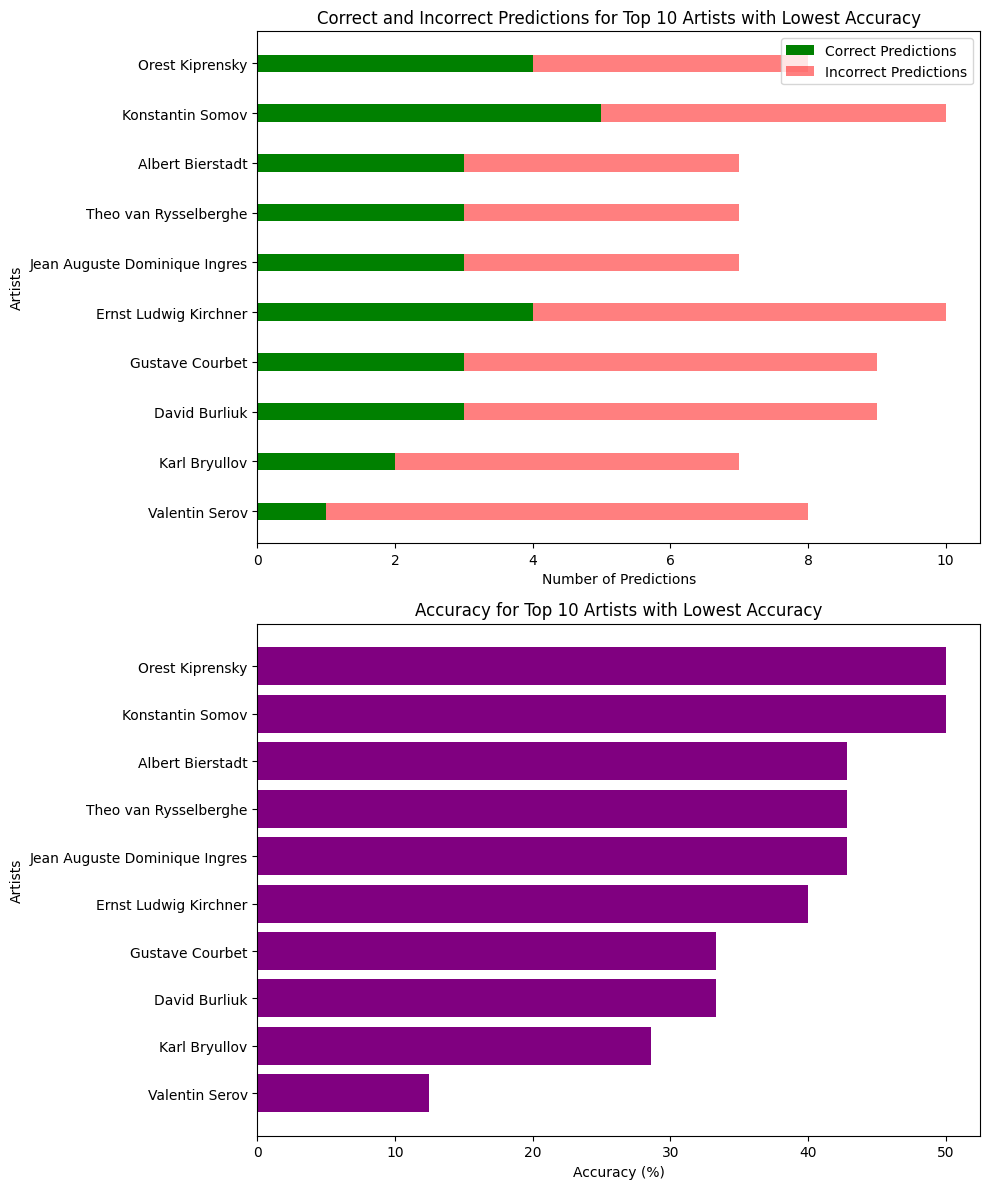

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Suponiendo que estas listas ya están definidas
artist_names = [artistas[i] for i in range(len(artistas))]
correct_predictions = [correct_preds[i] for i in range(len(artistas))]
incorrect_predictions = [total_preds[i] - correct_preds[i] for i in range(len(artistas))]
accuracy = [accuracy_per_class[i] * 100 for i in range(len(artistas))]

# Crear una lista de tuplas (artist_name, correct_predictions, incorrect_predictions, accuracy)
artist_data = list(zip(artist_names, correct_predictions, incorrect_predictions, accuracy))

# Ordenar por precisión en orden ascendente (menor precisión primero)
artist_data_sorted = sorted(artist_data, key=lambda x: x[3])

# Seleccionar los primeros 10 artistas con menor precisión
top_10_incorrect_artists = artist_data_sorted[:10]

# Desempaquetar los datos para los 10 artistas seleccionados
top_10_artist_names = [data[0] for data in top_10_incorrect_artists]
top_10_correct_predictions = [data[1] for data in top_10_incorrect_artists]
top_10_incorrect_predictions = [data[2] for data in top_10_incorrect_artists]
top_10_accuracy = [data[3] for data in top_10_incorrect_artists]

fig, axs = plt.subplots(2, 1, figsize=(10, 12))  # Ajustar el tamaño del gráfico si es necesario

bar_width = 0.35

# Correct and incorrect predictions graphics for top 10 incorrect artists
axs[0].barh(top_10_artist_names, top_10_correct_predictions, bar_width, label='Correct Predictions', color='g')
axs[0].barh(top_10_artist_names, top_10_incorrect_predictions, bar_width, left=top_10_correct_predictions, label='Incorrect Predictions', color='r', alpha=0.5)
axs[0].set_xlabel('Number of Predictions')
axs[0].set_ylabel('Artists')
axs[0].set_title('Correct and Incorrect Predictions for Top 10 Artists with Lowest Accuracy')
axs[0].legend()

# Accuracy by artist for top 10 incorrect artists
axs[1].barh(top_10_artist_names, top_10_accuracy, color='purple')
axs[1].set_xlabel('Accuracy (%)')
axs[1].set_ylabel('Artists')
axs[1].set_title('Accuracy for Top 10 Artists with Lowest Accuracy')

plt.tight_layout()
plt.show()


Artista: Koloman Moser, Aciertos: 0, Errores: 36, Total Predicciones: 36
Artista: Theo van Rysselberghe, Aciertos: 0, Errores: 34, Total Predicciones: 34
Artista: Edgar Degas, Aciertos: 0, Errores: 95, Total Predicciones: 95
Artista: Ferdinand Hodler, Aciertos: 0, Errores: 46, Total Predicciones: 46
Artista: Ernst Ludwig Kirchner, Aciertos: 0, Errores: 48, Total Predicciones: 48
Artista: William-Adolphe Bouguereau, Aciertos: 0, Errores: 42, Total Predicciones: 42
Artista: Felix Vallotton , Aciertos: 0, Errores: 60, Total Predicciones: 60
Artista: Francisco Goya, Aciertos: 0, Errores: 65, Total Predicciones: 65
Artista: Valentin Serov, Aciertos: 0, Errores: 41, Total Predicciones: 41
Artista: Orest Kiprensky, Aciertos: 0, Errores: 39, Total Predicciones: 39
Artista: Alfred Sisley, Aciertos: 0, Errores: 89, Total Predicciones: 89
Artista: Sir Lawrence Alma-Tadema, Aciertos: 1, Errores: 33, Total Predicciones: 34
Artista: Thomas Eakins, Aciertos: 0, Errores: 35, Total Predicciones: 35
Art

NameError: name 'artist_results' is not defined